## 13.7. 单发多框检测（SSD）

### 13.7.1. 模型

#### 13.7.1.1. 类别预测层

In [1]:
%matplotlib inline
import mindspore
from mindspore import nn
from d2l import mindspore as d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1, pad_mode='pad')

[WARNING] ME(300375:47194544307584,MainProcess):2023-04-03-16:15:37.357.548 [mindspore/common/_decorator.py:40] 'Fills' is deprecated from version 2.0 and will be removed in a future version, use 'ops.fill' instead.


#### 13.7.1.2. 边界框预测层

In [2]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1, pad_mode='pad')

#### 13.7.1.3. 连结多尺度的预测

In [3]:
def forward(x, block):
    return block(x)

Y1 = forward(d2l.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(d2l.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

((2, 55, 20, 20), (2, 33, 10, 10))

In [4]:
def flatten_pred(pred):
    return d2l.flatten(pred.permute(0, 2, 3, 1))

def concat_preds(preds):
    return d2l.concat([flatten_pred(p) for p in preds], axis=1)

In [5]:
concat_preds([Y1, Y2]).shape

(2, 25300)

#### 13.7.1.4. 高和宽减半块

In [6]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1, pad_mode='pad'))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2, 2))
    return nn.SequentialCell(*blk)

In [7]:
forward(d2l.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

(2, 10, 10, 10)

#### 13.7.1.5. 基本网络块

In [8]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.SequentialCell(*blk)

forward(d2l.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

#### 13.7.1.6. 完整的模型

In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [10]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [12]:
class TinySSD(nn.Cell):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def construct(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = d2l.concat(anchors, axis=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [13]:
net = TinySSD(num_classes=1)
X = d2l.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


### 13.7.2. 训练模型

#### 13.7.2.1. 读取数据集和初始化

In [14]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [15]:
net = TinySSD(num_classes=1)
trainer = nn.SGD(net.trainable_params(), learning_rate=0.2, weight_decay=5e-4)

#### 13.7.2.2. 定义损失函数和评价函数

In [16]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(axis=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(axis=1)
    return cls + bbox

In [17]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(axis=-1).astype(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float(((bbox_labels - bbox_preds) * bbox_masks).abs().sum())

#### 13.7.2.3. 训练模型

class err 2.85e-03, bbox mae 2.70e-03
6.8 examples/sec on 


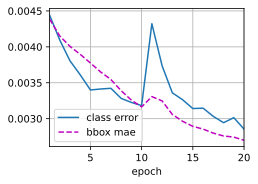

In [19]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])

def forward_fn(X, Y):
    # 生成多尺度的锚框，为每个锚框预测类别和偏移量
    anchors, cls_preds, bbox_preds = net(X)
    # 为每个锚框标注类别和偏移量
    bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
    # 根据类别和偏移量的预测和标注值计算损失函数
    l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                  bbox_masks).mean()
    return l, cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks, bbox_labels
    
grad_fn = mindspore.value_and_grad(forward_fn, None, trainer.parameters, has_aux=True)
    
def train_step(inputs, targets):
    (l, cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks, bbox_labels), grads = grad_fn(inputs, targets)
    trainer(grads)
    return l, cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks, bbox_labels
    
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.set_train()
    for features, target in train_iter:
        timer.start()
        l, cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks, bbox_labels = train_step(features, target)
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{train_iter.get_dataset_size()/ timer.stop():.1f} examples/sec on ')

### 13.7.3. 预测目标

In [20]:
img = mindspore.dataset.vision.read_image('../img/banana.jpg').astype('float32')
X = mindspore.Tensor(img.transpose(2,0,1), dtype=mindspore.float32).unsqueeze(0)

In [24]:
def predict(X):
    net.set_train(False)
    anchors, cls_preds, bbox_preds = net(X)
    cls_probs = d2l.softmax(cls_preds, axis=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors) # d2l.
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0][idx]

output = predict(X)

[WARNING] KERNEL(300375,2aec9fa87700,python):2023-04-03-17:11:46.720.731 [mindspore/ccsrc/kernel/kernel.h:514] CheckShapeNull] For 'Reshape', the shape of input cannot contain zero, but got (0, 1)
[WARNING] KERNEL(300375,2aec9fa87700,python):2023-04-03-17:11:46.723.968 [mindspore/ccsrc/kernel/kernel.h:514] CheckShapeNull] For 'Add', the shape of input_0 cannot contain zero, but got (0)
[WARNING] KERNEL(300375,2aec9fa87700,python):2023-04-03-17:11:46.734.618 [mindspore/ccsrc/kernel/kernel.h:514] CheckShapeNull] For 'Gather', the shape of indices cannot contain zero, but got (0)
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


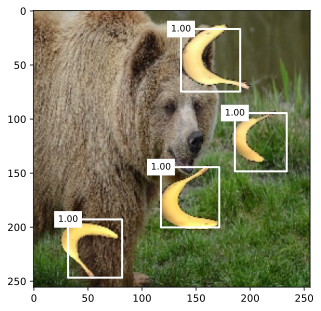

In [26]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * d2l.tensor((w, h, w, h))]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
img = X.numpy().squeeze().transpose(1,2,0)/255
display(img, output, threshold=0.9)

### 13.7.5. 练习

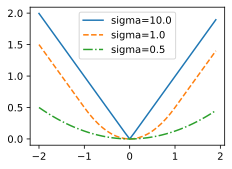

In [27]:
import numpy as np
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    
    return np.array(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = d2l.arange(-2, 2, 0.1).numpy()
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

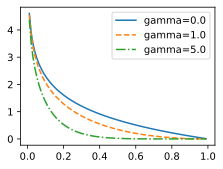

In [28]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * np.log(x)

x = np.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();